# Create meta-features
A continuation of the previous notebook.  I suspect making
meta features of two of my data sets, may help the third be
more predictive.  In this notebook I will evaluate the categorical data set.

## Method
For each individual data set (numeric, categorical, date), I'll try to find a reasonably good model, create a feature from the predicted output.  Then save the output, and pickle model for later use.

### Baseline
I'm trying to be better than a guess, so uniform baseline for me.

### Basic model
Compare a few basic linear models to see which works best with minimal tuning.

### Permutation Importance
After running that basic model, use permutation to figure out which features are the most important, and to build a model with only features that positively impact my model.

### Rebuild model
Run the model with the most important features. If unable to get any level of precision to my prediction, attempt to reduce dimensionality.

### Transform the entire dataset
transform the entire dataset by chunking to create our meta feature. Either through predictions + probabilities, or through dimension reduction.

### Save
Pickle the model, so it can be used on test sets and other notebooks. Save the predictions and possibly the probabilities as a separate dataframe to be merged with my main dataset in other notebooks.

## Evaluation
I'm evaluating for precision, based off the confusion matrix in my main notebook. I'm also keeping an eye on MCC, as that is the metric used by Bosch to evaluate their model.

In [1]:
import pandas as pd

folder = 'bosch-production-line-performance/'

response = pd.read_csv(folder + 'train_numeric.csv', usecols = ['Response'], 
               squeeze = True)

cat_iter = pd.read_csv(folder + 'train_categorical.csv', dtype = str, 
                        iterator = True, chunksize = 1000)

In [2]:
print(response.shape)
response.head()

(1183747,)


0    0
1    0
2    0
3    0
4    0
Name: Response, dtype: int64

In [3]:
chunks = []

for i in range(300):
    chunks.append(cat_iter.get_chunk())
    
cat = pd.concat(chunks, ignore_index = True)

print(cat.shape)
cat.head()

(300000, 2141)


,Id,L0_S1_F25,L0_S1_F27,L0_S1_F29,L0_S1_F31,L0_S2_F33,L0_S2_F35,L0_S2_F37,L0_S2_F39,L0_S2_F41,...,L3_S49_F4225,L3_S49_F4227,L3_S49_F4229,L3_S49_F4230,L3_S49_F4232,L3_S49_F4234,L3_S49_F4235,L3_S49_F4237,L3_S49_F4239,L3_S49_F4240
0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
X = cat.drop(columns = 'Id')
y = response.iloc[: X.shape[0]]

X.shape, y.shape

((300000, 2140), (300000,))

## Baseline

In [5]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score, matthews_corrcoef

base_model = DummyClassifier(strategy = 'uniform', random_state = 42)

base_model.fit(X, y)

y_pred_base = base_model.predict(X)

def metrics(y_true, y_pred):
    #We are setting zero division to 0, because a dataset this imbalance
    #is very likely generate warnings otherwise.
    print('Our Precision is: ', precision_score(y_true, y_pred, 
                                               zero_division = 0))
    print('Our MCC is: ', matthews_corrcoef(y_true, y_pred))
    
metrics(y, y_pred_base)

Our Precision is:  0.005613488353509929
Our MCC is:  -0.0004876871771416818


## Basic model

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = .20,
    random_state = 42,
    shuffle = True,
    stratify = y
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((240000, 2140), (60000, 2140), (240000,), (60000,))

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRFClassifier
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce

In [8]:
#I don't expect SKlearns random forest to work well.  Thsi data set is mostly
#missing data (see above exploration).  By that alone, imputing will heavily
#skew this dataset.  I expect that the XGBoost model will work better, since
#it can handle missing values
%time
RFC_pipe = make_pipeline(
    SimpleImputer(strategy = 'most_frequent'),
    ce.OrdinalEncoder(),
    RandomForestClassifier(n_jobs = -1, random_state = 42)
)

RFC_pipe.fit(X_train, y_train)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.1 µs


Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='most_frequent',
                               verbose=0)),
                ('ordinalencoder',
                 OrdinalEncoder(cols=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                      13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                      23, 24, 25, 26, 27, 28, 29, ...],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                       

In [9]:
%time
y_pred_RFC = RFC_pipe.predict(X_test)

metrics(y_test, y_pred_RFC)

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 2.62 µs
Our Precision is:  0.3333333333333333
Our MCC is:  0.04372020661309092


In [10]:
#well that is much better than baseline.  Something to work with.  Lets do a
#quick XGBRFClassifier to see if that improves things any.
#commented out to save memory, since this model has 0 precision
# %time
# XGBRF_pipe = make_pipeline(
#     ce.OrdinalEncoder(),
#     XGBRFClassifier()
# )

# XGBRF_pipe.fit(X_train, y_train)

In [11]:
# %time
# y_pred_XGBRF = XGBRF_pipe.predict(X_test)

# metrics(y_test, y_pred_XGBRF)

## Permutation Importance

In [12]:
#of the two, it definitely looks like a random forest classifier was able to get
#at least some level precision out of the set.  So lets do a little permutation
#and see what comes up as the most important features.
import eli5
from eli5.sklearn import PermutationImportance

transformer = make_pipeline(
    SimpleImputer(strategy = 'most_frequent'),
    ce.OrdinalEncoder()
)

X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)

model = RandomForestClassifier(n_jobs = -1, random_state = 42)

model.fit(X_train_transformed, y_train)

/home/felix/anaconda3/envs/anaconda_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/felix/anaconda3/envs/anaconda_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [13]:
permuter = PermutationImportance(
    model,
    scoring = 'precision',
    n_iter = 5,
    random_state = 42
)

permuter.fit(X_test_transformed, y_test)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [14]:
#Simple imputer removing features again.  I need to figure out what is being
#removed

removed_features = []
for col in X_train.columns:
    if X_train[col].isnull().sum() == X_train.shape[0]:
        removed_features.append(col)

len(removed_features)

576

In [15]:
feature_names = X_test.columns.tolist()

feature_names = list(set(feature_names) - set(removed_features))

eli5.show_weights(
    permuter,
    top = None,
    feature_names = feature_names
)

Weight,Feature
0 ± 0.0000,L2_S27_F3195
0 ± 0.0000,L2_S27_F3184
0 ± 0.0000,L2_S26_F3119
0 ± 0.0000,L2_S28_F3262
0 ± 0.0000,L1_S25_F2308
0 ± 0.0000,L3_S30_F3645
0 ± 0.0000,L1_S24_F830
0 ± 0.0000,L1_S25_F2165
0 ± 0.0000,L3_S30_F3563
0 ± 0.0000,L3_S47_F4186


Okay good to see.  Permutation importance tells me if my model performs better or worse when data is shuffled around in each column. So those last four features performed better after a shuffle.  But not by much, these are still
fundamentally very close to 0.  So I feel justified leaving them in my model,
since they still may have some relational value.

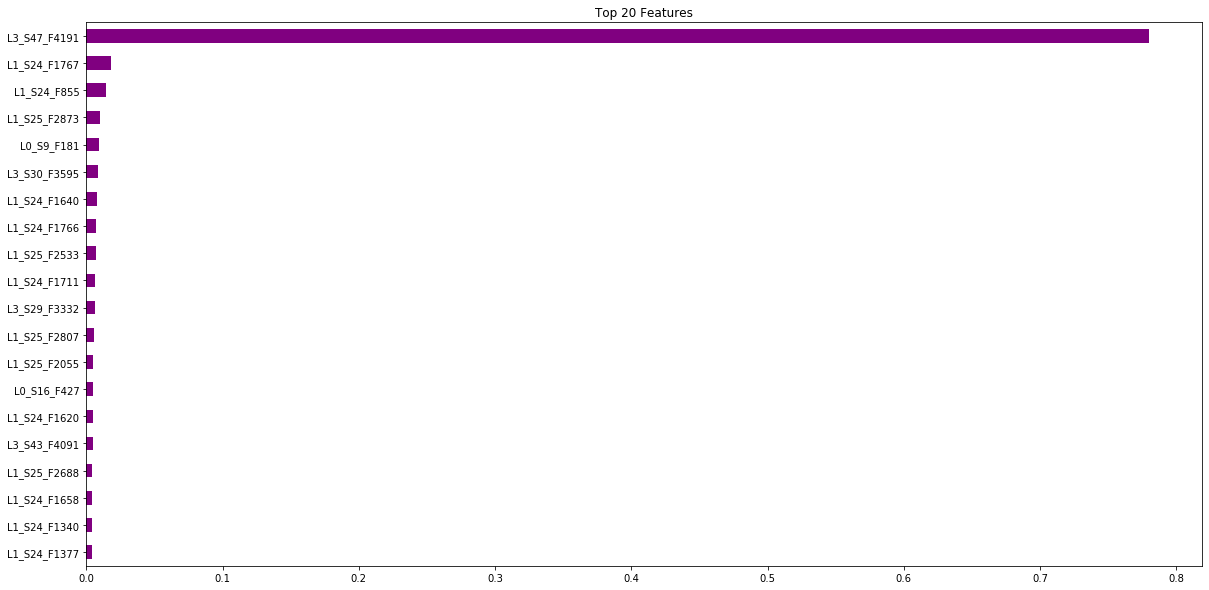

In [35]:
#What I didn't do was check my feature importances from my original model.
#lets go ahead and get an idea of what features are contributing what.
import matplotlib.pyplot as plt

importances = pd.Series(model.feature_importances_, feature_names)

#only interest in the top few
n = 20

plt.figure(figsize = (20, n/2))
plt.title(f'Top {n} Features')
plot = importances.sort_values()[-n:].plot.barh(color = 'purple');

fig = plt.gcf()
fig.savefig('categorical_feature_imp.png')

Holy smokes we have a winner! Line 3 Station 47 catogorizing on feature 4191. What a relief to see there is something in there.

In [65]:
import plotly.express as px
import chart_studio.plotly as py
from plotly.graph_objects import FigureWidget

In [62]:
bosch_colors = ['#D3141B',
                '#573B8F',
                '#004A93',
                '#359ACD',
                '#0A8EAE',
                '#009778',
                '#12863B',
                '#91BE59']

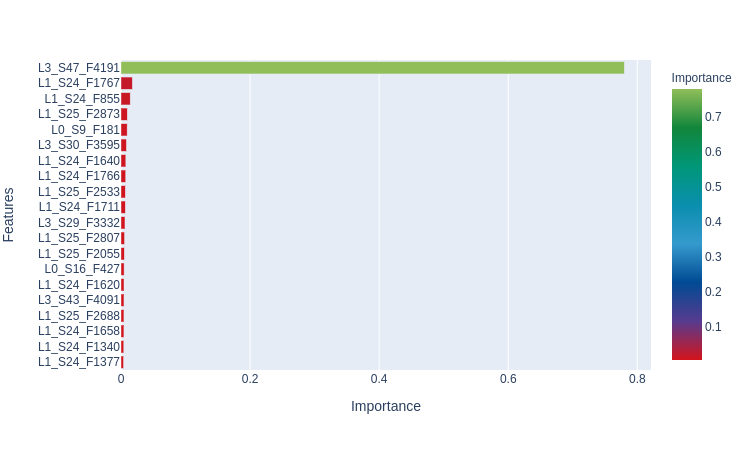

In [63]:
#lets try to do this again with a nicer looking tool.

df = pd.DataFrame(importances.sort_values()[-n:], columns = ['Importance'])

df.reset_index(inplace = True)

df.rename(columns = {'index': 'Features'}, inplace = True)

fig = px.bar(df, x = 'Importance', y = 'Features', color = 'Importance',
             color_continuous_scale = bosch_colors, orientation = 'h')

widge = FigureWidget(fig)

widge.show()

In [64]:
py.plot(fig, filename = 'categorical-feature-importances', auto_open = True)

'https://plot.ly/~jpeone/1/'

## Rebuild model
No real reason to rebuild, just remove the few columns and see if that improves things.

In [72]:
#I'm going to try running the model on only the top 20 columns

columns = list(df['Features'])

top20_pipe = make_pipeline(
    SimpleImputer(strategy = 'most_frequent'),
    ce.OrdinalEncoder(),
    RandomForestClassifier(n_jobs = -1, random_state = 42)
)

top20_pipe.fit(X_train[columns], y_train)

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='most_frequent',
                               verbose=0)),
                ('ordinalencoder',
                 OrdinalEncoder(cols=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                      13, 14, 15, 16, 17, 18, 19],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 0, 'data_type': dt...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity

In [74]:
y_pred_top20 = top20_pipe.predict(X_test[columns])

metrics(y_test, y_pred_top20)

Our Precision is:  0.0
Our MCC is:  0.0


/home/felix/anaconda3/envs/anaconda_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning:

invalid value encountered in double_scalars



In [75]:
#welp, it was worth a try, but there is still must be a lot of signal in those
#other features.

#I think that means I really do need to have the majority of this set in place
#to get to that 33% precision that I got above. I think I'd like to look at the
#feature importances of the bottom 20 compared to the top 20.

#top 20 importances
importances.sort_values()[-n:]

L1_S24_F1377    0.004089
L1_S24_F1340    0.004321
L1_S24_F1658    0.004517
L1_S25_F2688    0.004520
L3_S43_F4091    0.004607
L1_S24_F1620    0.004639
L0_S16_F427     0.004776
L1_S25_F2055    0.005107
L1_S25_F2807    0.005601
L3_S29_F3332    0.006146
L1_S24_F1711    0.006716
L1_S25_F2533    0.006969
L1_S24_F1766    0.007336
L1_S24_F1640    0.007473
L3_S30_F3595    0.008596
L0_S9_F181      0.009525
L1_S25_F2873    0.009677
L1_S24_F855     0.014240
L1_S24_F1767    0.017767
L3_S47_F4191    0.780136
dtype: float64

In [79]:
importances.sort_values()[:n]

L2_S28_F3261    0.0
L2_S26_F3116    0.0
L1_S24_F783     0.0
L2_S28_F3251    0.0
L1_S24_F1435    0.0
L1_S25_F1993    0.0
L2_S28_F3231    0.0
L1_S25_F2822    0.0
L1_S25_F1990    0.0
L1_S25_F2806    0.0
L0_S21_F476     0.0
L1_S24_F1380    0.0
L1_S24_F1080    0.0
L1_S25_F2841    0.0
L1_S25_F2084    0.0
L0_S10_F267     0.0
L3_S44_F4123    0.0
L1_S25_F1964    0.0
L1_S24_F861     0.0
L1_S24_F1412    0.0
dtype: float64

In [83]:
#okay that gives me one last idea.  What if I just cut out all the importances
#that are zero.  Anything above 0 is kept.

mask = importances > 0

better_than_zero = importances.index[mask].tolist()

len(better_than_zero)

263

In [85]:
#Okay, that is actually pretty reasonable reduction.  Lets give it one more shot

btz_pipe = make_pipeline(
    SimpleImputer(strategy = 'most_frequent'),
    ce.OrdinalEncoder(),
    RandomForestClassifier(n_jobs = -1, random_state = 42)
)

btz_pipe.fit(X_train[better_than_zero], y_train)

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='most_frequent',
                               verbose=0)),
                ('ordinalencoder',
                 OrdinalEncoder(cols=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                      13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                      23, 24, 25, 26, 27, 28, 29, ...],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                       

In [86]:
y_pred_btz = btz_pipe.predict(X_test[better_than_zero])

metrics(y_test, y_pred_btz)

Our Precision is:  0.2
Our MCC is:  0.023671084478091162


Interesting.  Lost both some precision and MCC.  So even though they might not have been the most important features, it seems they were still contributing something to my final model. Interesting lesson to learn. Thousands of very low importance features, are still better than hundreds of higher importance features.  
As painful as it is waiting for a very wide data set to process, I think I need to commit to it if I'm going to make this stacking feature any good. Time to run this overnight.

## Transform the entire dataset
Ran out of memory in this notebook.  See the next wrangle notebook for a paired down model, run on the entire dataset.